# Sweep Line Voronoi Diagram (Fortune's Algorithm)

The Voronoi diagram is a partitioning of a plane into regions based on the distance to a specific point. Given a set of points, the Voronoi diagram is the set of points in the plane that are equidistant to the input points. The Voronoi diagram is also known as a Dirichlet tessellation.

In dimension 2, a Voronoi diagram of $n\geq 3$ sites has at most $2n-5$ vertices and $3n-6$ edges. The Voronoi diagram can be constructed in $O(n\log n)$ time using Fortune's algorithm.

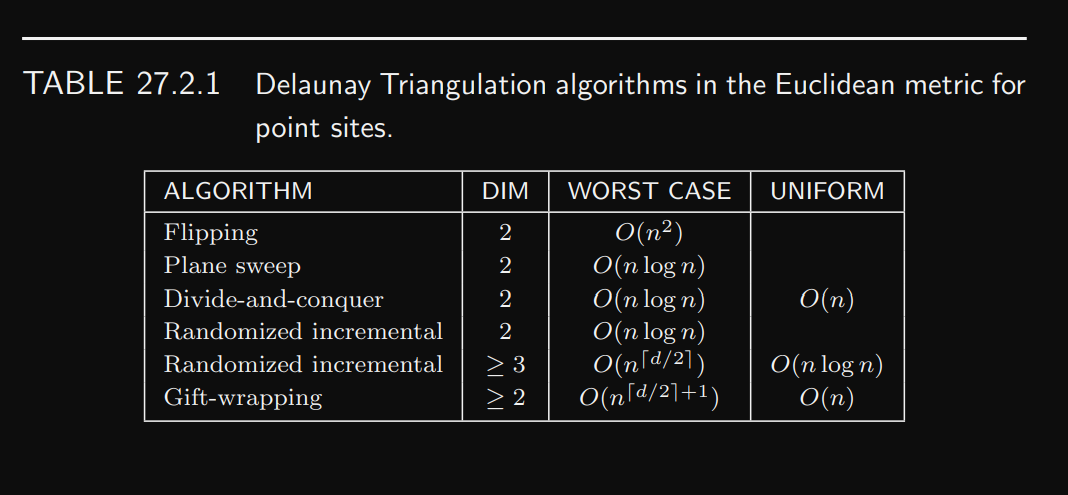

Reference:
- https://en.wikipedia.org/wiki/Fortune%27s_algorithm
- Handbook of DISCRETE AND COMPUTATIONAL GEOMETRY THIRD EDITION - Chapter 27 

## C++ implementation

In [124]:
from ctypes import *

# Load the shared library
lib = cdll.LoadLibrary('./voronoi.so')

# Define the function signature
# float* voronoiDiagramWrapper(float *xValues, float *yValues, int numValues, float minX, float maxX, float minY, float maxY, float minDistanceBetweenSites, GraphEdge **edges, int *numEdges)
lib.voronoiDiagramWrapper.argtypes = [POINTER(c_float), POINTER(c_float), c_int, c_float, c_float, c_float, c_float, c_float, POINTER(POINTER(c_void_p)), POINTER(c_int)]
lib.voronoiDiagramWrapper.restype = POINTER(c_float)

Generating Voronoi diagram from C++!


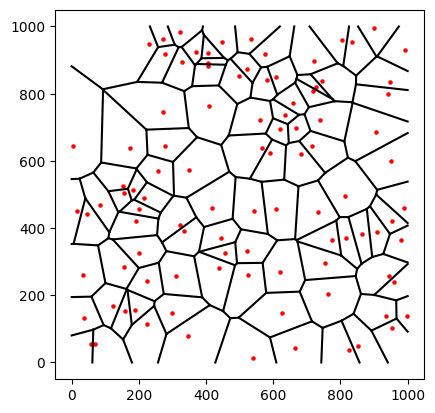

In [128]:
import matplotlib.pyplot as plt
import random

points = []
for i in range(100):
    points.append((random.uniform(0, 1000), random.uniform(0, 1000)))

# Convert the points to a flat array
xValues = (c_float * len(points))()
yValues = (c_float * len(points))()

for i, p in enumerate(points):
    xValues[i] = p[0]
    yValues[i] = p[1]

# Call the function
edges = POINTER(c_void_p)()
numEdges = c_int(0)
result = lib.voronoiDiagramWrapper(xValues, yValues, len(points), 0, 1000, 0, 1000, 0, byref(edges), byref(numEdges))

# Extract the edges
n = int(result[0])
edges = []
for i in range(1, n * 4, 4):
    a = result[i]
    b = result[i + 1]
    c = result[i + 2]
    d = result[i + 3]
    edges.append((a, b, c, d))

# Plot the Voronoi diagram
for a, b, c, d in edges:
    plt.plot([a, c], [b, d], 'k-')

for p in points:
    plt.scatter(p[0], p[1], c='r', s=5)

plt.gca().set_aspect('equal', adjustable='box')
plt.show()


## Python implementation


In [129]:
from math import sqrt

class Point(object):
    """A point in the plane

    Attributes:
        x: float, the x coordinate
        y: float, the y coordinate

    Properties:
        square: float, the square of the norm of the vector (x, y)
        norm: float, the norm of the vector (x, y)
    """
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def __hash__(self) -> int:
        return hash(self.x+self.y)

    def __repr__(self):
        return "%s(%r, %r)" % (self.__class__.__name__, self.x, self.y)

    def __add__(self, other):
        return self.__class__(self.x + other.x, self.y + other.y)

    def __neg__(self):
        return self.__class__(-self.x, -self.y)

    def __sub__(self, other):
        return self + (-other)

    def __div__(self, other):
        return self.__class__(self.x / other, self.y / other)
    
    def __lt__(self, other):
      if self.x == other.x:
        return self.y < other.y
      return self.x < other.x
    
    def __le__(self, other):
      if self.x == other.x:
        return self.y <= other.y
      return self.x <= other.x

    def __eq__(self, other):
      return self.x == other.x and self.y == other.y
    
    def __ne__(self, other):
      return self.x != other.x or self.y != other.y
    
    def __gt__(self, other):
      if self.x == other.x:
        return self.y > other.y
      return self.x > other.x
    
    def __ge__(self, other):
      if self.x == other.x:
        return self.y >= other.y
      return self.x >= other.x
  
    def __abs__(self):
        return self.norm

    @property
    def square(self):
        return self.x**2 + self.y**2

    @property
    def norm(self):
        return sqrt(self.square)


class VoronoiEdge(object):
    """An half-edge of the resulting graph.

    The attributes of a VoronoiEdge are used internally to define the corresponding half-edge.

    Properties:
        line: (Point, Point), a point and a vector defining the line on which the edge lies
        left_site: Point, the site on the left of the edge
        right_site: Point, the site on the right of the edge
        vertex_from: Point, the start point of the edge, or None if the edge is not bounded
        vertex_to: Point, the end point of the edge, or None if the edge is not bounded
    """
    def __init__(self, origin, twin, site, next_edge):
        self._origin = origin
        self._twin = twin
        self._site = site
        self._next_edge = next_edge
        self._cut_origin = None

    def __repr__(self):
        return "%s(left_site=%r, right_site=%r, vertex_from=%r, vertex_to=%r)" % (
            self.__class__.__name__, self.left_site, self.right_site, self.vertex_from, self.vertex_to)

    def _iter_neighbours(self):
        he = self
        while he is not None:
            yield he
            he = he._next_edge

    @property
    def line(self):
        """Returns p, v such that p is the point of the line lying in the middle of the two sites
        and v is a vector directing the line in the direction that keeps the left site on the left"""
        diff = self.right_site - self.left_site
        return Point((self.left_site.x + self.right_site.x) / 2, (self.left_site.y + self.right_site.y) / 2), Point(diff.y, -diff.x)

    @property
    def left_site(self):
        return self._site

    @property
    def right_site(self):
        return self._twin._site

    @property
    def vertex_from(self):
        if self._origin is not None:
            return self._origin
        return self._cut_origin

    @property
    def vertex_to(self):
        return self._twin.vertex_from

    def trim(self, x_min, x_max, y_min, y_max, from_vertex=True):
        """Trim an infinite edge to make it fit in a bounding box"""
        result = []
        origin_vertex = self.vertex_from if from_vertex else self.vertex_to
        rotation_x = 2*origin_vertex.x
        rotation_y = 2*origin_vertex.y
        x0, y0 = self.line[0].x, self.line[0].y
        for a, b, obj in (
            (-self.line[1].x, -self.line[1].y, self),
            (self.line[1].x, self.line[1].y, self._twin),):
            if getattr(obj, '_origin') is None:
                x_limit = x_max if a > 0 else x_min
                y_limit = y_max if b > 0 else y_min
                if a != 0:
                    t = (x_limit - x0) / a
                    _y = y0 + b * t
                    if y_min <= _y <= y_max:
                        result.append(origin_vertex)
                        result.append(Point(rotation_x-x_limit, rotation_y-_y))
                        continue
                assert b != 0
                t = (y_limit - y0) / b
                _x = x0 + a * t
                assert x_min <= _x <= x_max
                result.append(origin_vertex)
                result.append(Point(rotation_x-_x, rotation_y-y_limit))

        return result

#
# Generic helpers and data types
#

def determinant(v1, v2):
    """Determinant of two vectors, represented by Point instances"""
    return v1.x * v2.y - v1.y * v2.x

def circumcircle(p1, p2, p3):
    """The circumcircle of three points"""
    d = 2 * (p1.x * (p2.y - p3.y) + p2.x * (p3.y - p1.y) + p3.x * (p1.y - p2.y))
    x = (p1.square * (p2.y - p3.y) + p2.square * (p3.y - p1.y) + p3.square * (p1.y - p2.y)) / d
    y = (p1.square * (p3.x - p2.x) + p2.square * (p1.x - p3.x) + p3.square * (p2.x - p1.x)) / d
    p = Point(x, y)
    r = (p1 - p).norm

    return (p, r)


class Heap(object):
    """A basic implementation of a heap"""
    def __init__(self, items=None):
        if items is None:
            self._items = []
        else:
            self._items = list(items)
            N = len(self._items) // 2
            for i in range(0, N):
                self._heapify(N - i)

    def __repr__(self):
        return "%s(%r)" % (self.__class__.__name__, self._items)

    def __nonzero__(self):
        return bool(self._items)

    def _heapify(self, i):
        size = len(self._items)
        left = 2 * i
        right = left + 1

        m = i
        if left <= size and self._items[left - 1] > self._items[m - 1]:
            m = left
        if right <= size and self._items[right - 1] > self._items[m - 1]:
            m = right
        if m != i:
            _temp = self._items[i - 1]
            self._items[i - 1] = self._items[m - 1]
            self._items[m - 1] = _temp
            self._heapify(m)

    def insert(self, item):
        self._items.append(item)
        self._sift_up()

    def _sift_up(self):
        k = len(self._items)
        v = self._items[k - 1]
        while k > 1 and v > self._items[k // 2 - 1]:
            self._items[k - 1] = self._items[k // 2 - 1]
            k = k // 2
        self._items[k - 1] = v

    def pop_max(self):
      try:
        if len(self._items) == 1:
            return self._items.pop()
        v = self._items[0]
        self._items[0] = self._items.pop()
        self._sift_down()
        return v
      except:
        pass

    def _sift_down(self):
        k = 1
        l = len(self._items)
        v = self._items[0]
        while k <= l // 2:
            j = 2 * k
            if j < l and self._items[j - 1] <= self._items[j]:
                j += 1
            if v >= self._items[j - 1]:
                break
            self._items[k - 1] = self._items[j - 1]
            k = j
        self._items[k - 1] = v

class Queue(Heap):
    """A queue based on a heap"""
    def __iter__(self):
        while self:
            yield self.pop_max()

#
# Main class used for Voronoï diagram computation
#

class Voronoi(object):
    """A Voronoï diagram, computed using Fortune's algorithm

    Args:
        sites: list of Point, the sites we want to compute the diagram of
        bounding_box: tuple of 4 float, (x_min, x_max, y_min, y_max) used to trim the edges, optional

    Attributes:
        vertices: list of Point, the vertices of the resulting Voronoï diagram
        edges: list of VoronoiEdge, the edges of the resulting Voronoï diagram
    """
    def __init__(self, sites, bounding_box=None):
        self._queue = Queue([SiteEvent(s) for s in sites])
        self._beach_line = None
        self._faces = {}
        self.vertices = []
        self.edges = []

        self._compute()
        if bounding_box is not None:
            for e in self.edges:
                e.trim(*bounding_box)

    def _compute(self):
        for event in self._queue:
            if event is None:
              break
            if isinstance(event, SiteEvent):
                self._handle_site_event(event)
            elif event is not None and event.is_valid:
                self._handle_circle_event(event)

    def _create_twins(self, site1, site2):
        half_edge = VoronoiEdge(None, None, site1, self._faces.get(site1, None))
        half_edge._twin = VoronoiEdge(None, half_edge, site2, self._faces.get(site2, None))
        self.edges.append(half_edge)
        self._faces[site1] = half_edge
        self._faces[site2] = half_edge._twin

        return half_edge

    def _handle_site_event(self, event):
        # Insert new arc
        inserted = self._insert_beach_line(event.site)
        if inserted.left is None:
            return
        # If inserted on another, remove its bound events
        if inserted.left is not None and inserted.left.circle_event is not None:
            inserted.left.circle_event = None
        # DLL things
        self._create_twins(inserted.site, inserted.left.site)
        # Check on left and right for circle events (converging)
        for e in _build_circle_events(inserted=inserted):
            self._queue.insert(e)

    def _handle_circle_event(self, event):
        # Delete the disappearing arc from beach_line
        removed_on = self._remove_from_beach_line(event.arc)
        # Remove all circles events involving it
        if event.arc.left is not None and event.arc.left.circle_event is not None:
            event.arc.left.circle_event = None
        if event.arc.right is not None and event.arc.right.circle_event is not None:
            event.arc.right.circle_event = None
        # Add vertex
        self.vertices.append(event.circle[0])

        # HE things
        new_half_edge = self._create_twins(removed_on.right.site, removed_on.site)
        new_half_edge._origin = event.circle[0]

        for left, right in (
            (event.arc.left.site, event.arc.site),
            (event.arc.site, event.arc.right.site)):
            half_edge = None
            for he in self._faces[left]._iter_neighbours():
                if he._twin._site == right:
                    half_edge = he
                    break
            half_edge._origin = event.circle[0]
        # Check two new triples for circle events
        for e in _build_circle_events(removed_on=removed_on):
            self._queue.insert(e)

    def _find_arc_above(self, site):
        if self._beach_line is None:
            return
        for arc in self._beach_line:
            low, high = arc.get_interval(site.y)
            if high is None or high >= site.x:
                assert low is None or site.x >= low
                return arc

    def _insert_beach_line(self, site):
        arc = self._find_arc_above(site)
        if arc is None:
            self._beach_line = Arc(site)
            return self._beach_line
        _temp = arc.right
        arc.right = Arc(site, left=arc)
        arc.right.right = Arc(arc.site, left=arc.right, right=_temp)
        if _temp is not None:
            _temp.left = arc.right.right
        return arc.right

    def _remove_from_beach_line(self, arc):
        if arc == self._beach_line:
            self._beach_line = arc.right
        if arc.left is not None:
            arc.left.right = arc.right
        if arc.right is not None:
            arc.right.left = arc.left
        return arc.left

def get_parabolas_intersections(point1, point2, sweep_line_y):
    """Compute the intersections of two parabolas

    This method will compute the intersections of the two parabolas defined by
    point1, point2 and the horizontal line with ordinate sweep_line_y lying below those points.

    The first intersection returned corresponds to the transition from point1 to point2 occuring when
    moving along the beach line from left to right.

    Args:
        point1: tuple (x, y) of float numbers with y >= sweep_line_y
        point2: tuple (x, y) of float numbers with y >= sweep_line_y
        sweep_line_y: float
    """
    (a, b) = point1.x, point1.y
    (c, d) = point2.x, point2.y

    b -= sweep_line_y
    d -= sweep_line_y

    # The equation will be A.x^2 + B.x + C = 0
    A = (1 / b - 1 / d) / 2
    B = c / d - a / b
    C = (b - d + a**2 / b - c**2 / d) / 2

    delta = B**2 - 4 * A * C

    assert delta > 0

    x1 = (- B - sqrt(delta)) / (2 * A)
    x2 = (- B + sqrt(delta)) / (2 * A)

    y1 = (x1 - a)**2 / (2 * b) + b / 2
    y2 = (x2 - a)**2 / (2 * b) + b / 2

    result = (Point(x1, y1 + sweep_line_y), Point(x2, y2 + sweep_line_y))

    result = result if A >= 0 else (result[1], result[0])

    if b > d:
        return result[0], result[1]
    else:
        return result[1], result[0]


class Arc(object):
    """An arc of the beach line"""
    def __init__(self, site, left=None, right=None, circle_event=None):
        self.site = site
        self.left = left
        self.right = right
        self.circle_event = circle_event

    def __iter__(self):
        item = self
        while item is not None:
            yield item
            item = item.right

    def get_interval(self, sweep_line_y):
        low = None
        high = None
        if self.left is not None:
            low = get_parabolas_intersections(self.left.site, self.site, sweep_line_y)[0].x
        if self.right is not None:
            high = get_parabolas_intersections(self.site, self.right.site, sweep_line_y)[0].x
        return low, high


class FortuneEvent(object):

    def __lt__(self, other):
      return self.y < other.y
    
    def __le__(self, other):
      return self.y <= other.y

    def __eq__(self, other):
      return self.y == other.y
    
    def __ne__(self, other):
      return self.y != other.y
    
    def __gt__(self, other):
      return self.y > other.y
    
    def __ge__(self, other):
      return self.y >= other.y

    @property
    def y(self):
        raise NotImplementedError()


class SiteEvent(FortuneEvent):

    def __init__(self, site):
        self.site = site

    def __repr__(self):
        return u"SiteEvent at y=%s" % self.y

    @property
    def y(self):
        return self.site.y


class CircleEvent(FortuneEvent):

    def __init__(self, arc):
        self.arc = arc
        self.circle = circumcircle(arc.left.site, arc.site, arc.right.site)
        arc.circle_event = self
    
    def __repr__(self):
        return u"CircleEvent at y=%s" % self.y

    @property
    def y(self):
        (center, radius) = self.circle
        return center.y - radius

    @property
    def is_valid(self):
        return self.arc.circle_event == self

def _build_circle_events(inserted=None, removed_on=None):
    to_check = []

    if inserted is not None:
        if inserted.left is not None and inserted.left.left is not None:
            to_check.append(inserted.left)
        if inserted.right is not None and inserted.right.right is not None:
            to_check.append(inserted.right)
    if removed_on is not None:
        if removed_on.left is not None and removed_on.right is not None:
            to_check.append(removed_on)
        if removed_on.right is not None and removed_on.right.right is not None:
            to_check.append(removed_on.right)

    for arc in to_check:
        a, b, c = arc.left.site, arc.site, arc.right.site
        if determinant(b - a, c - b) <= 0:
            yield CircleEvent(arc)

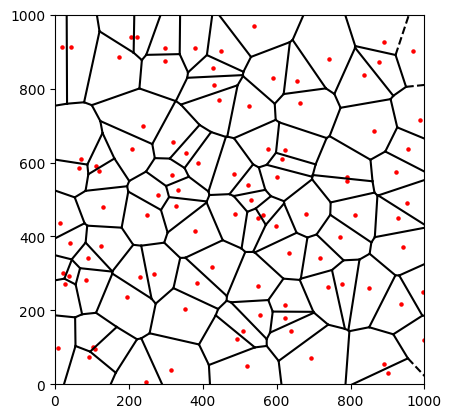

In [133]:
# Plot the Voronoi diagram
import matplotlib.pyplot as plt
import random

points = [Point(random.uniform(0, 1000), random.uniform(0, 1000)) for _ in range(100)]
v = Voronoi(points)

x_max = 1000
x_min = -1000
y_max = 1000
y_min = -1000

for e in v.edges:
    if e.vertex_from is None:
        line = e.trim(x_min, x_max, y_min, y_max, from_vertex=False)
        plt.plot([line[0].x, line[1].x], [line[0].y, line[1].y], 'k--')

    elif e.vertex_to is None:
        line = e.trim(x_min, x_max, y_min, y_max, from_vertex=True)
        plt.plot([line[0].x, line[1].x], [line[0].y, line[1].y], 'k--')

    else:
        plt.plot([e.vertex_from.x, e.vertex_to.x], [e.vertex_from.y, e.vertex_to.y], 'k-')

for p in points:
    plt.scatter(p.x, p.y, c='r', s=5)

plt.gca().set_aspect('equal', adjustable='box')
plt.setp(plt.gca(), xlim=(0, 1000), ylim=(0, 1000))
plt.show()